# PROJECT 2

Problem Statement:

Can we use house data to predict the price a house will sell for in our city of Ames? Having such a model will benefit the people of our community. People who want to sell their homes can have an idea of how much they will get from the sale. People who want to buy a home will have an idea of what kind of offer they should make on a house to get a fair deal. The more predictive our model is the more helpful it will be for the prospective home buyers. Looking at data from house sales we can use linear, ridge, and lass regression to try to predict how much houses will sell for based on a variety of features. Our model will mostly be used for prediction. To determine how good our model is we will be using R squared scores. R squared score measures how much of the variance in sale prices can be explained by our model. However, we can also use inference to figure out how specific features effect the house price. Then prospective buyers can try to find good deals by looking for features they value more than the overall population. We collected data from house sales between 2006 and 2010. Overall that gives us a database of over 2,000 house sales and 81 features. We will use the data to try and build the model.



In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from plotnine import *
from plotnine.data import *
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
house_df = pd.read_csv('datasets/train.csv') #load data

In [3]:
house_df['SalePrice'].describe() #look at output variable. 

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

The house sales range from under 13000 dollars to over 610000 dollars. There is quite a bit of variation. We will see how much the model can explain.

In [4]:
house_df.info() #check the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

There  are alot of NAs in the dataset. Looking at the data dictionary the NAs actually mean something for the categorical variables. One way to deal with this is to create dummies since we will need to do it for the model anyway. We will encode the categorical variaables that seem relevant. 

In [5]:
zone = pd.get_dummies(house_df['MS Zoning'], drop_first =True)
sub_class = pd.get_dummies(house_df['MS SubClass'], drop_first =True)
st = pd.get_dummies(house_df['Street'], drop_first =True)
n = pd.get_dummies(house_df['Neighborhood'], drop_first =True)
c1 = pd.get_dummies(house_df['Condition 1'], drop_first =True)
b = pd.get_dummies(house_df['Bldg Type'], drop_first =True)
h = pd.get_dummies(house_df['House Style'], drop_first =True)
heat =pd.get_dummies(house_df['Heating'], drop_first =True)
g =pd.get_dummies(house_df['Garage Type'], drop_first =True)

In [6]:
house_df = house_df.join(zone) # join the new variables 
house_df = house_df.join(sub_class)
house_df = house_df.join(st)
house_df = house_df.join(n)
house_df = house_df.join(c1)
house_df = house_df.join(b)
house_df = house_df.join(h)
house_df = house_df.join(heat)
house_df = house_df.join(g)

The dataset is now 158 columns. To make it more manageable I will remove columns that do not seem important. 

In [7]:
house_df.drop(columns = ['Id', 'PID'], inplace =True) # just id columns
house_df.drop(columns = ['Lot Frontage', 'Alley', 'Pool QC', 'Misc Feature', 'Fence', 'Mas Vnr Type', 'Fireplace Qu'], inplace =True) #these have NAs without obvious meaning. We have enough features so I feel safe dropping them.


There are still 156 features. We will use correlation to determine what is important. The remaining NAs indicate that the house does not have that feature. 

In [8]:
house_df =house_df.fillna(0)

Now the NAs have been filled correctly

Before I start modeling there are outliers in the data. In general I think outliers should be kept unless we know there are errors because they provide information. However, I found 4 observations that should be dropped. They are radically different than any other houses in the dataset. Because there are so few of them the model will not really be able to provide any usefull information. By removing them we will have a better model.

In [9]:
house_df =house_df.drop([960, 1885])

house_df = house_df.reset_index(drop=True)

house_df =house_df.drop([1711])

house_df =house_df.drop([1326])

house_df = house_df.reset_index(drop=True)

To start the model I will be looking for variables that have a high correlation with sale price. I can do that with a correlation plot in seaborn comparing the variables to sale price. Before I do that I wanted to examine the distribution of Sale Price.

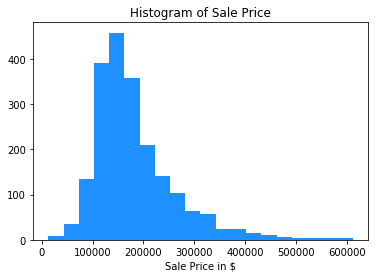

In [10]:
plt.hist(house_df['SalePrice'], bins=20, color ="dodgerblue");
plt.title('Histogram of Sale Price');
plt.xlabel('Sale Price in $');

Sale Price appears to be a normal distribution with a right skew. There are some extremely high sales that could skew the model. It is something to keep in mind during the modeling phase. There are many houses in the 10000 to 20000 range.

In [11]:
corr = house_df.corr()[['SalePrice']].sort_values('SalePrice' ,ascending =False) #variable correlation with saleprice.

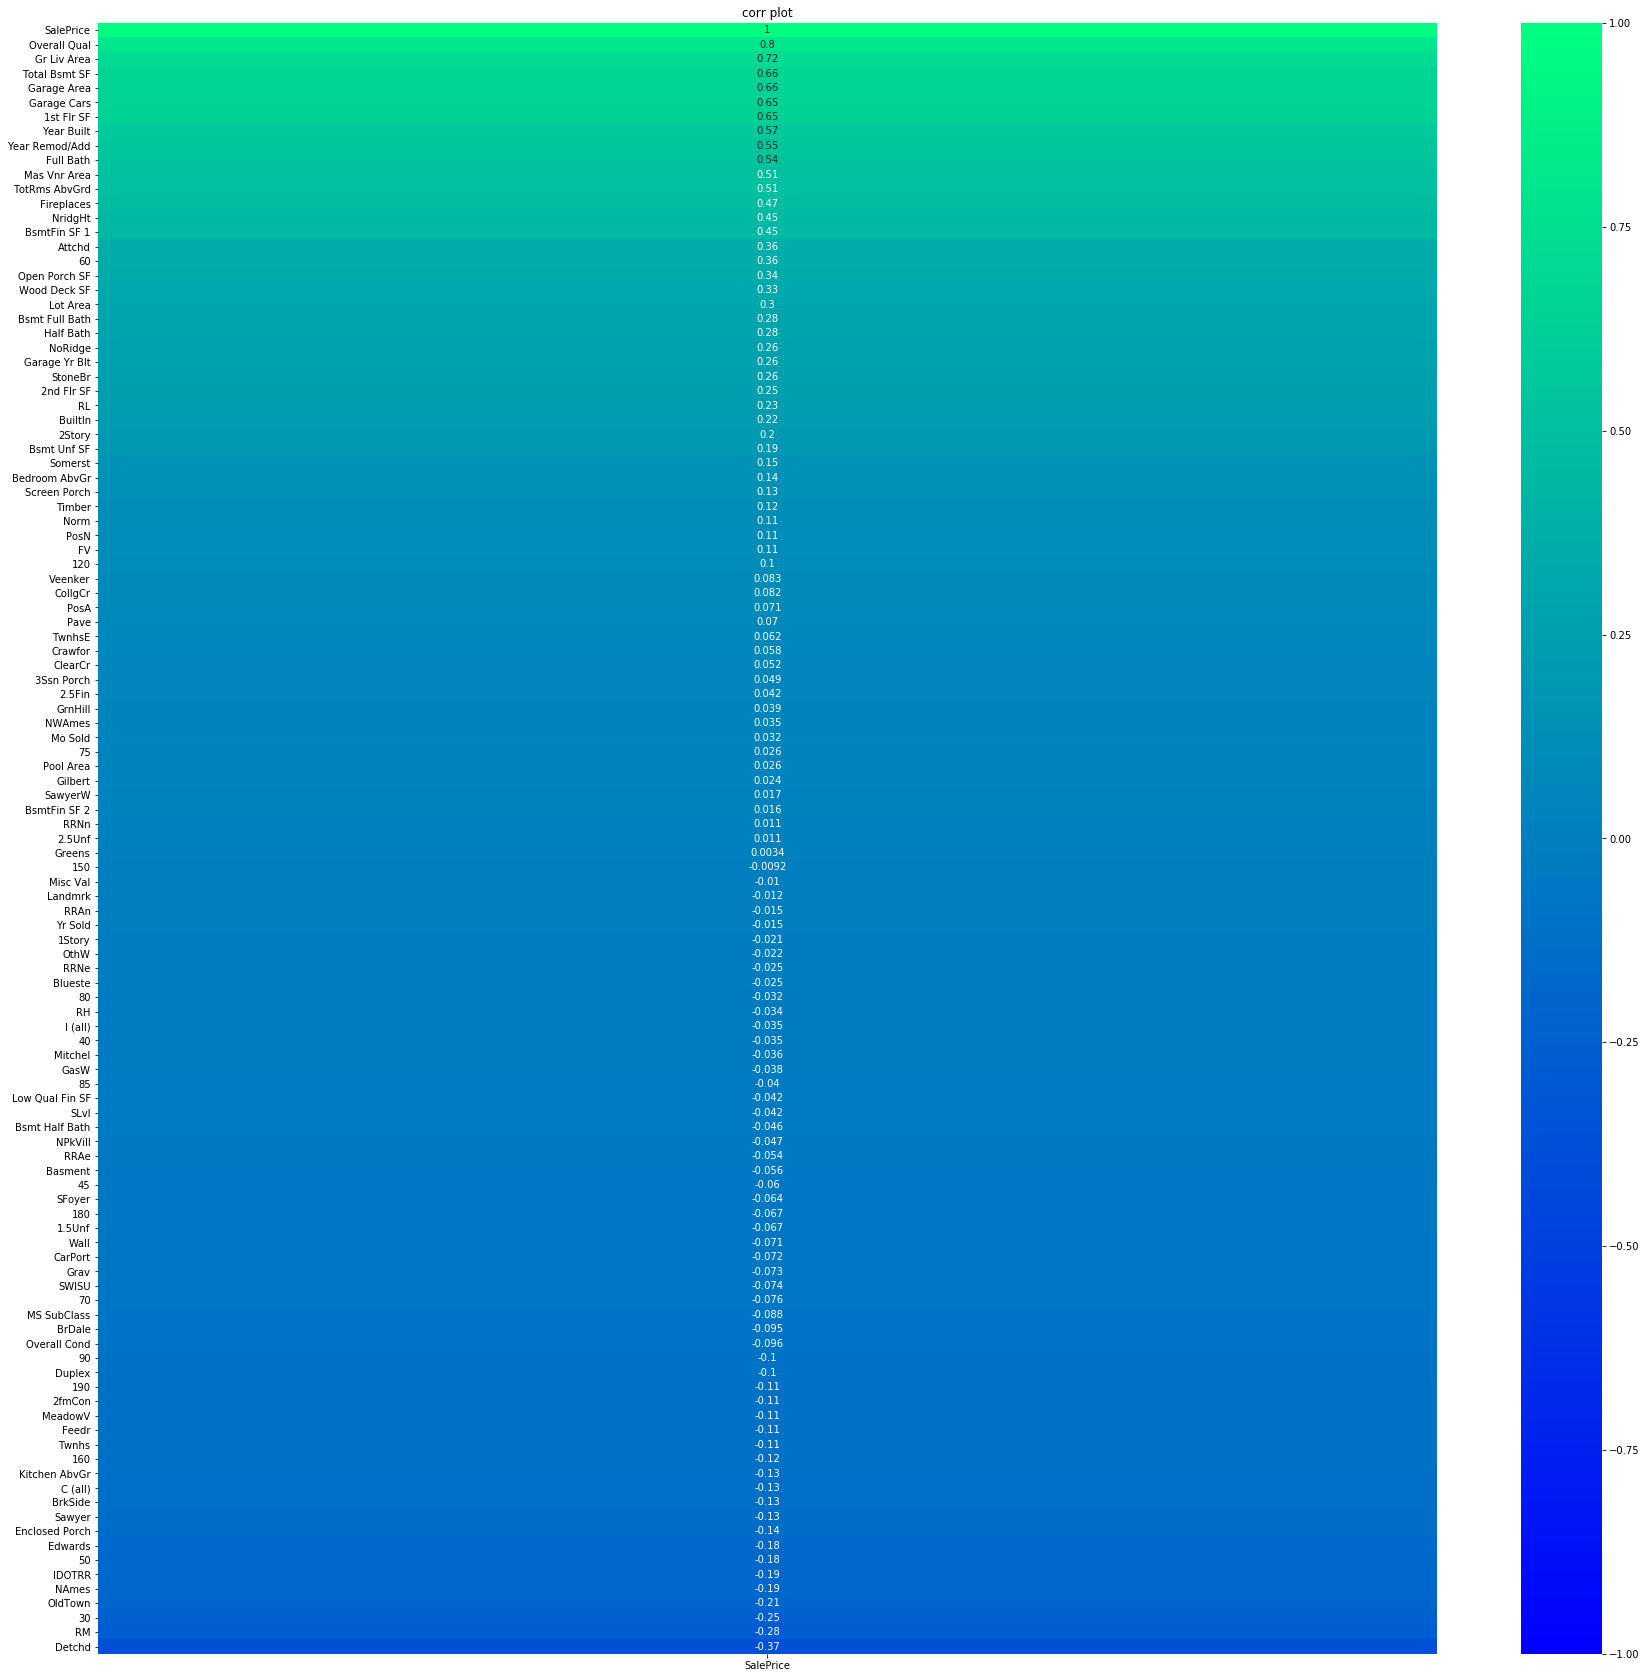

In [12]:
plt.figure(figsize = (30, 30))
sns.heatmap(corr, annot =True, cmap = 'winter', vmin=-1, vmax =1);
plt.title('corr plot'); #heatmap

There are so many variables that it is hard to read. To make this more managable I will only include features that have a correlation with the absolute values of 0.4 or better. Anything with a correlation between -0.4 and 0.4 is probably not going to be changing sale price that much. By limiting the model to fewer features we will make it easier for users to interpret. It is also less likley to suffer from overfitting where the model performs much better on training data than testing data. Picking 0.4 as a cutoff for linear models was a practice suggested to me while I was in academia.

In [13]:
df = house_df[['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Garage Cars', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'NridgHt', 'BsmtFin SF 1']].copy() #https://sparkbyexamples.com/pandas/pandas-create-new-dataframe-by-selecting-specific-columns/#:~:text=You%20can%20create%20a%20new,added%20to%20the%20original%20ones was a reference.

In [14]:
corr = df.corr()[['SalePrice']].sort_values('SalePrice' ,ascending =False) #variable correlation with saleprice again. 

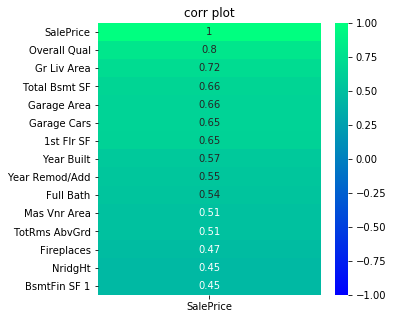

In [15]:
plt.figure(figsize = (5, 5))
sns.heatmap(corr, annot =True, cmap = 'winter',vmin=-1, vmax =1);
plt.title('corr plot');

This chart is easier to see. Its interesting that none of the variables had a negative correlation with sales price large enough to make it in the model. There are many variables with postitive correlations that might give me a good model. Using scatter plots I can look at the variables most correlated with Sale Price. By looking at them closely I can determine whether it makes sense to throw them into the model. I will start with the most correlated ones and go through the whole list of 14 shown in the heatmap. Overall Quality is the most correlated one.

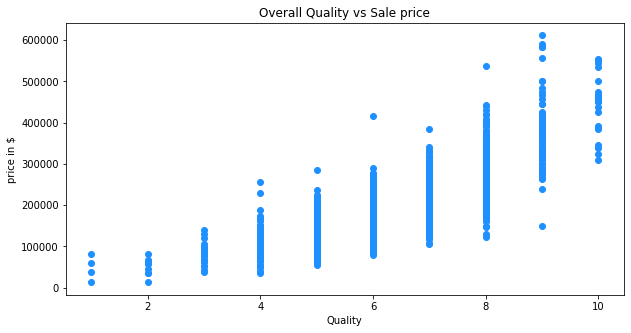

In [16]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['Overall Qual'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Overall Quality vs Sale price')
plt.xlabel('Quality')
plt.ylabel('price in $');

Overall Quality is a ordinal variable. According to https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/ ordinal data can be dealt with with ordinal encoding which the variable already has. The higher the number the better the quality of the material and finish of the house. There is a clear correlation between better quality and price. Another way to look at this is with a boxplot.

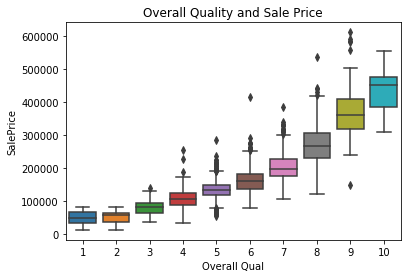

In [17]:
sns.boxplot(x = 'Overall Qual', y ='SalePrice', data =house_df); # inspired by https://seaborn.pydata.org/generated/seaborn.boxplot.html
plt.title('Overall Quality and Sale Price');

Here is the boxplot. It shows the same pattern as the scatter plot. This seems like the good variable to include in the model. For ordinal variables boxplots are better visuals than scatter plots. Next I wanted to look at the variable distribution.

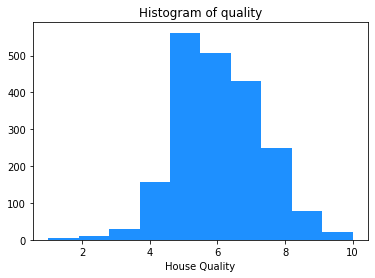

In [18]:
plt.hist(house_df['Overall Qual'], bins=10, color = 'dodgerblue');
plt.title('Histogram of quality'); 
plt.xlabel('House Quality');

The distribution looks like a left skewed normal with most houses having between a 5 and an 8.  Overall Quality will be in the model. The next variable is the ground living area. It is the total area of the house above ground.

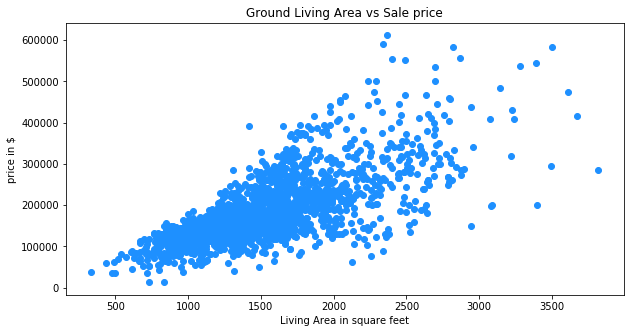

In [19]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['Gr Liv Area'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Ground Living Area vs Sale price')
plt.xlabel('Living Area in square feet')
plt.ylabel('price in $');

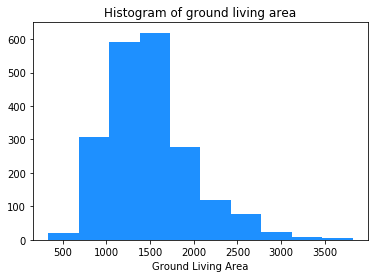

In [20]:
plt.hist(house_df['Gr Liv Area'], bins=10, color ='dodgerblue');
plt.title('Histogram of ground living area'); 
plt.xlabel('Ground Living Area');

Ground Living Area is continuous. It appears to a skewed normal distribution. It appears that there is a linear relationship and Ground Living Area should be included in the model. The next variable is basement area.

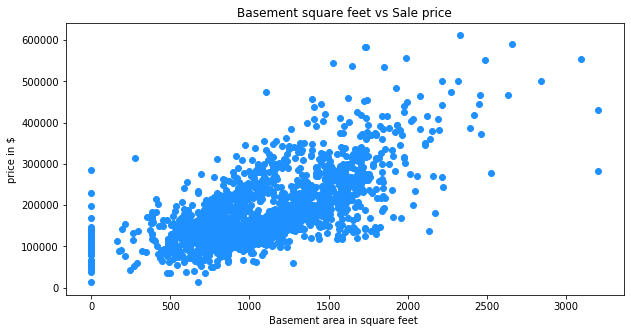

In [21]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['Total Bsmt SF'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Basement square feet vs Sale price')
plt.xlabel('Basement area in square feet ')
plt.ylabel('price in $');

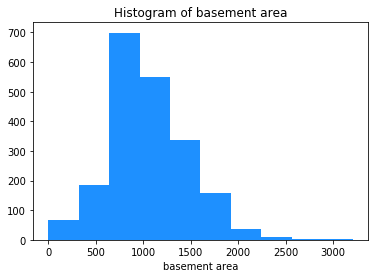

In [22]:
plt.hist(house_df['Total Bsmt SF'], bins=10, color ='dodgerblue');
plt.title('Histogram of basement area'); 
plt.xlabel('basement area');

This also looks like a good model to include in the model. It is correlated with sale price and has an approximately normal distribution.

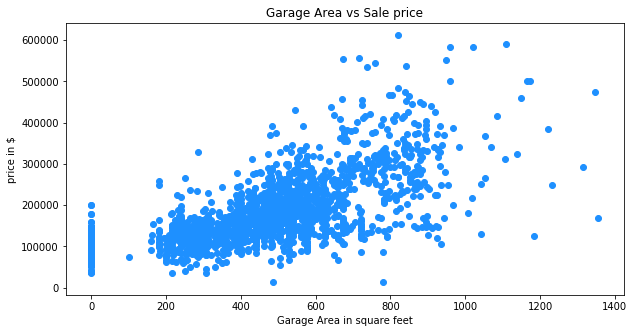

In [23]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['Garage Area'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Garage Area vs Sale price')
plt.xlabel('Garage Area in square feet')
plt.ylabel('price in $');

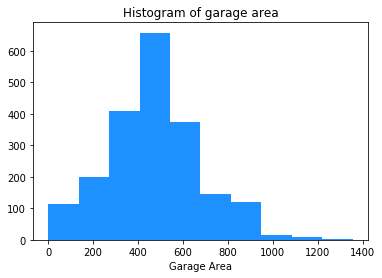

In [24]:
plt.hist(house_df['Garage Area'], bins=10, color = 'dodgerblue');
plt.title('Histogram of garage area'); 
plt.xlabel('Garage Area');

There is also a linear relationship here so Garage Area should be in the model as well. It also appears to be a normal distribution.

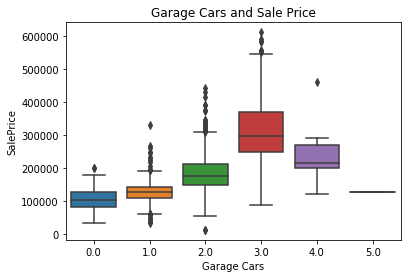

In [25]:
sns.boxplot(x = 'Garage Cars', y ='SalePrice', data =house_df);
plt.title('Garage Cars and Sale Price');

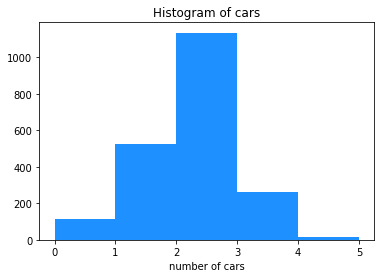

In [26]:
plt.hist(house_df['Garage Cars'], bins=5, color = 'dodgerblue');
plt.title('Histogram of cars'); 
plt.xlabel('number of cars');

Garage Cars is a discrete variable. It has a normal-ish distribution a clear correlation with sale price as well. However there are two issues. First it is not clear if the correlation is linear because 4 cars has a lower mean than 3 cars. Also, we should check for multicollinearity since the last two variables were both garage related. Multicollinearity is when our independant variables are highly correlated with each other. 

Multicollinearity makes it impossible to have an inferential model. It can also cause problems for a predicitve model. We can check for it with another heatmap.

In [27]:
corr2 =df.corr()

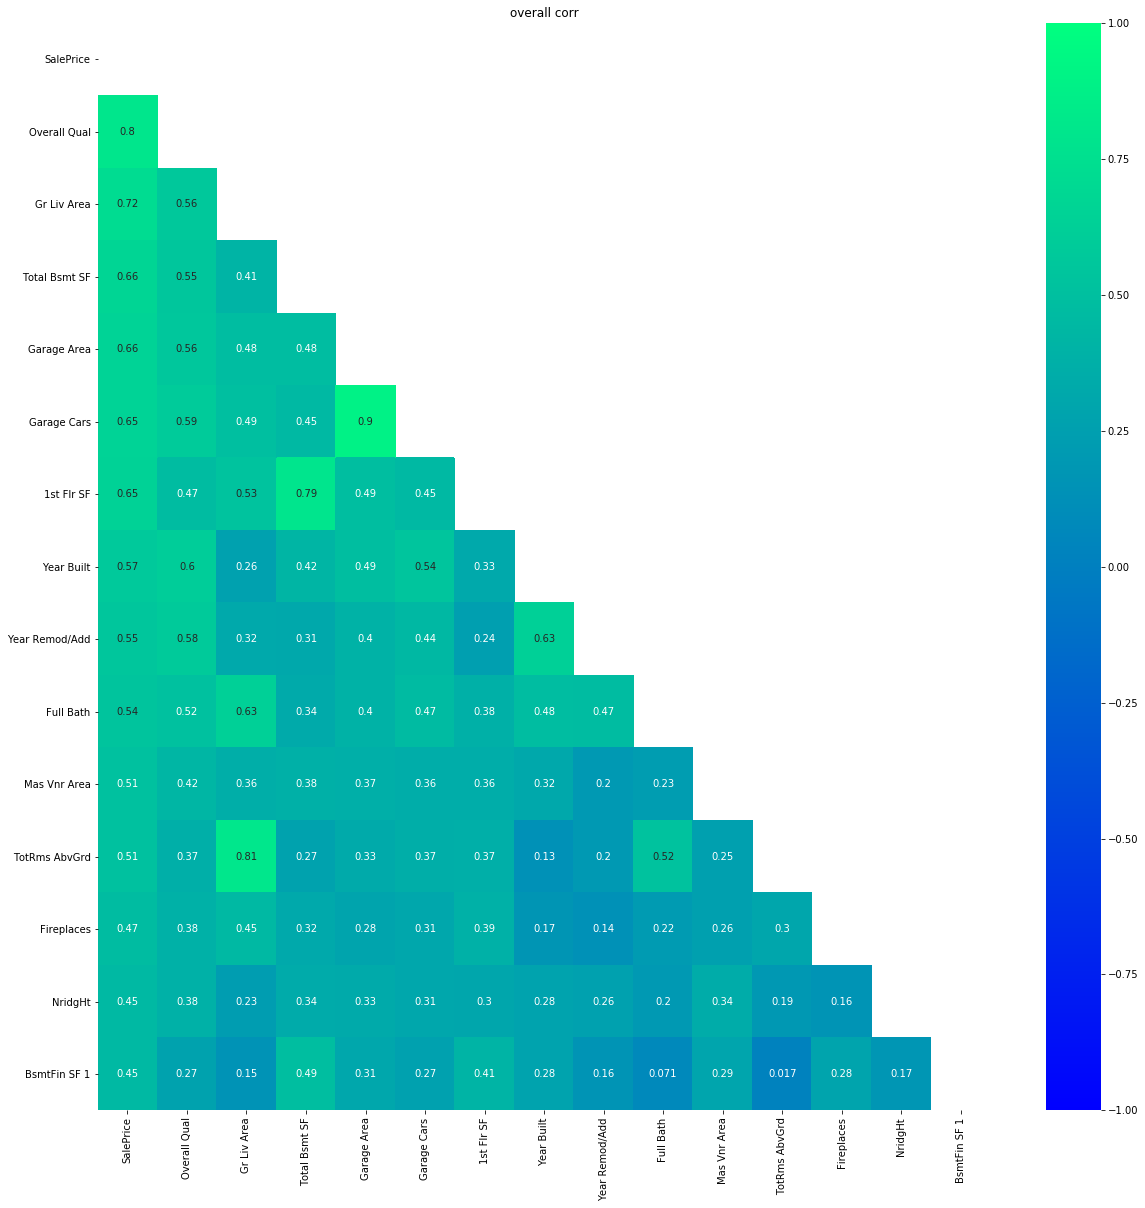

In [28]:
plt.figure(figsize = (20, 20))
mask = np.zeros_like(corr2)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr2, mask = mask, annot =True, cmap = 'winter', vmin=-1, vmax =1);
plt.title('overall corr');

There is a 0.9 correlation between Garage Area and Garage Cars so we should only include one in the model. This chart will also be useful to make sure no other overly correlated variables make it into the model. There are a few other pairs of variables that seem highly correlated. When there are two highly correlated variables I will pick the one that has the highest overall correlation with sale price. Variables with correlations above 0.6 I considered to correlated. This means I will drop 5 variables from the model. They are Garage cars, total rooms above grade, 1st floor square feet, year remod/add, and full bath. That still leaves 9 variables for the model.

The next variable is Year Built.

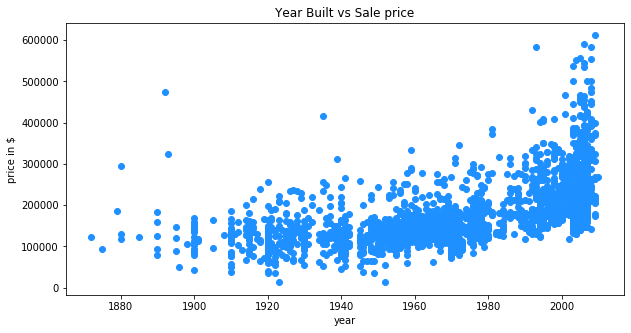

In [29]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['Year Built'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Year Built vs Sale price')
plt.xlabel('year')
plt.ylabel('price in $');

This is not a linear relationship with sale price. Therefore we would not include this feature in the model. The next variable is masonry veneer area.

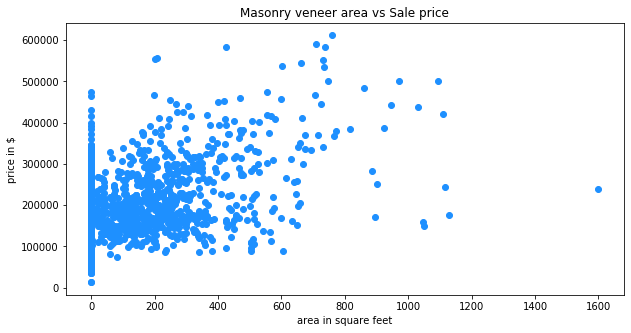

In [30]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['Mas Vnr Area'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Masonry veneer area vs Sale price')
plt.xlabel('area in square feet')
plt.ylabel('price in $');

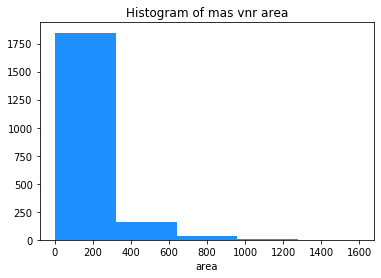

In [31]:
plt.hist(house_df['Mas Vnr Area'], bins=5, color = 'dodgerblue');
plt.title('Histogram of mas vnr area'); 
plt.xlabel('area');

At this point the correlation is hard to see and there are alot of houses with 0. However I will still include it in the model. Based on the correlation score we know the relationship still exists. 

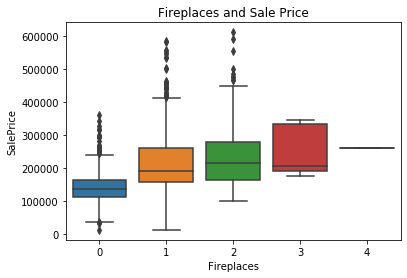

In [32]:
sns.boxplot(x = 'Fireplaces', y ='SalePrice', data =house_df);
plt.title('Fireplaces and Sale Price');

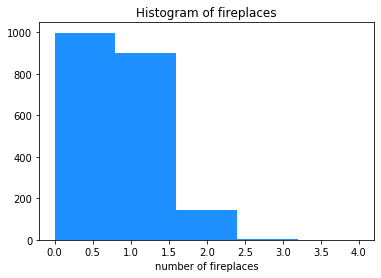

In [33]:
plt.hist(house_df['Fireplaces'], bins=5, color = 'dodgerblue');
plt.title('Histogram of fireplaces'); 
plt.xlabel('number of fireplaces');

Fireplaces is a little skewed but it correlates with sale price. The next variable is the only dummy variable correlated enough to make it into the model. A 1 means the house is in the Northridge Heights region and a 0 means it is not.

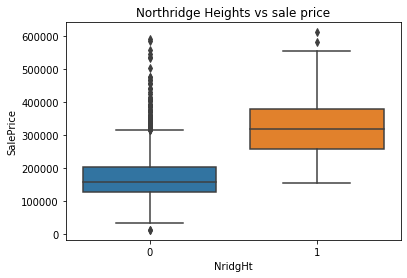

In [34]:
sns.boxplot(x = 'NridgHt', y ='SalePrice', data =house_df);
plt.title('Northridge Heights vs sale price');

Houses in Northrige Heights cost quite a bit more than houses in other areas. The final variable to look at in EDA is finished area in the basement. 

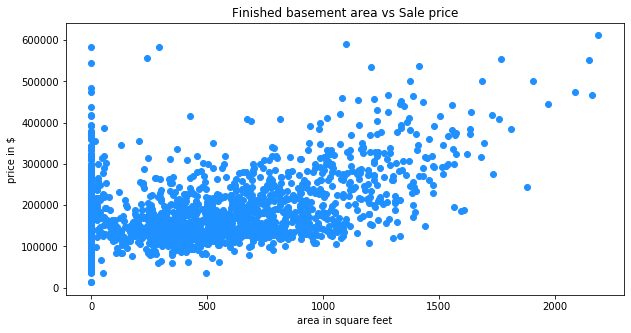

In [35]:
plt.figure(figsize = (10, 5))
plt.scatter(x = house_df['BsmtFin SF 1'], y = house_df['SalePrice'], color ='dodgerblue')
plt.title('Finished basement area vs Sale price')
plt.xlabel('area in square feet')
plt.ylabel('price in $');

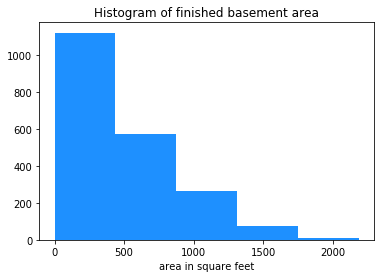

In [36]:
plt.hist(house_df['BsmtFin SF 1'], bins=5, color = 'dodgerblue');
plt.title('Histogram of finished basement area'); 
plt.xlabel('area in square feet');

This variable also looks worth including. Now that EDA is finished it is time to run the predictive model.

# Linear Regression Predictive Model

In linear regression we find the best line to minimizes errors while predicting the value of sales price from our features. As long as our model is performs better then the baseline (assuming all the houses sell for the average sale cost) it has value.

The variables have very different scales so it makes sense to scale them before running the model. It is not as important with linear regression as it is with other models.

In [37]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Mas Vnr Area', 'Fireplaces', 'NridgHt','BsmtFin SF 1'] # set up the features and output for models
X = df[features]
y = df['SalePrice']
sc = StandardScaler()
Xs = sc.fit_transform(X) #scale features

The data is divided into training and testing sets. The model will be trained on the training data and then tested on the testing data.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state = 5) # set up the regression and split the data
lr =LinearRegression()
lr.fit(X_train, y_train);

To get a sense of how well the model will do 5 fold cross validation will be performed. We will average the performance of the 5 models.

In [39]:
cross_val_score(estimator = lr,
               X = X_train,
               y = y_train).mean()

0.8487071094142546

The score here is the r squared score. This measures the amount of variation in sale price explained by the model. It ranges from 0 to 1. 

We will expect the model to be able to explain around 85% of the variance. The model is performing well on the training data. It is either a good model or a model with overfitting. 

There are many metrics to measure how well a regression is doing. We will focus on the r squared because it is easy to explain.

In [40]:
lr.score(X_train, y_train)

0.8522425859376038

In [41]:
lr.score(X_test, y_test)

0.8368369248310732

The model performs almost well on the test data as the train data. It explains over 80% of the variance for the test data. Therefore it does not seem like the model is dealing with underfitting or overfitting. While it is always possible to do better this model is explaining most of the variance. It will be provide a useful estimate for the cost of a house.

For comparison we will look at a couple other metrics. MAE is the absolute magnitude of residuals. SSE is the sum of the residuals squared. MSE is the average squared distance between predicted and actual values. We will uses these metrics to compare this model with the ridge and lasso models in the next section

In [42]:
predictions = lr.predict(X_test)
residuals  = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
sse = (residuals **2).sum()
mse = mean_squared_error(y_test, predictions)

In [43]:
print(mae, sse, mse)

22558.88804631358 510102604021.58594 996294148.47966


In [44]:
print(lr.intercept_)
print(lr.coef_)

181344.5853380545
[29956.52314497 24259.493892   10586.77393594  9667.20192782
  4289.54732482  3750.69958464  7891.67268779 12106.62826602]


In [45]:
list(zip(X.columns, lr.coef_))

[('Overall Qual', 29956.52314497336),
 ('Gr Liv Area', 24259.49389200449),
 ('Garage Area', 10586.773935935258),
 ('Total Bsmt SF', 9667.201927824233),
 ('Mas Vnr Area', 4289.547324817435),
 ('Fireplaces', 3750.699584641162),
 ('NridgHt', 7891.672687789283),
 ('BsmtFin SF 1', 12106.628266018382)]

Here the the equation coefficients. This will only be relevent in the inference section. First I will use ridge and lasso regressions to try and build an even better regression model. Ridge and Lasso are most effective when the linear regression is has a big overfitting problems. However there is slight overfitting so perhaps ridge and lasso will help.

# Ridge and Lasso Regression

In [46]:
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas = r_alphas, scoring = 'r2', cv = 5) #find the optimal alpha for ridge regression
ridge_cv.fit(X_train, y_train);
ridge_cv.alpha_

8.11130830789687

Using the best alpha we will see how the ridge regression performs.

In [47]:
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train, y_train)
ridge.score(X_train, y_train)

0.8522360625044745

In [48]:
ridge.score(X_test, y_test)

0.836970125307292

The ridge regression has almost identical scores to the original linear regression. The coeficients are almost identical too.

In [49]:
print(ridge.coef_)

[29762.45098474 24141.98607044 10639.30388794  9736.91888744
  4352.19417209  3827.42468996  7893.13913087 12020.54639707]


In [50]:
list(zip(X.columns, ridge.coef_))

[('Overall Qual', 29762.45098473899),
 ('Gr Liv Area', 24141.986070436473),
 ('Garage Area', 10639.303887939319),
 ('Total Bsmt SF', 9736.91888744242),
 ('Mas Vnr Area', 4352.19417208533),
 ('Fireplaces', 3827.424689964601),
 ('NridgHt', 7893.1391308695665),
 ('BsmtFin SF 1', 12020.54639707178)]

Next I will try lasso regression.

In [51]:
l_alphas = np.logspace(-3, 0, 100)
lasso= LassoCV(alphas = l_alphas, cv = 5, max_iter = 50_000, n_jobs = -1)
lasso .fit(X_train, y_train); 
lasso.alpha_
lasso.score(X_train, y_train)

0.8522425848454829

In [52]:
lasso.score(X_test, y_test)

0.8368391058707052

In [53]:
print(lasso.coef_)

[29954.63006742 24260.40620673 10588.4368023   9668.76486872
  4289.69496048  3749.6897289   7890.48154088 12105.12271109]


In [54]:
list(zip(X.columns, lasso.coef_))

[('Overall Qual', 29954.630067422127),
 ('Gr Liv Area', 24260.406206733926),
 ('Garage Area', 10588.436802305),
 ('Total Bsmt SF', 9668.764868724633),
 ('Mas Vnr Area', 4289.694960476682),
 ('Fireplaces', 3749.689728900139),
 ('NridgHt', 7890.481540877273),
 ('BsmtFin SF 1', 12105.122711092106)]

Lasso regression has very similar  r squared scores and coefficients to ridge regression and linear regression. I think the fact that ridge and lasso did not dramatically improve the linear model means the model is pretty good. Going forward I would use the linear regression model over the ridge or lasso one. It produces almost the same results and is easier to explain to the general public.

In [55]:
predictionsR = ridge.predict(X_test)
residualsR  = y_test - predictionsR
mae = mean_absolute_error(y_test, predictionsR)
sse = (residualsR **2).sum()
mse = mean_squared_error(y_test, predictionsR)

In [56]:
print(mae, sse, mse)

22524.29406193611 509686174570.83075 995480809.7086538


Compared to the linear regression, ridge has a slighly lower mae and sse but a slightly higher mse. From this I still believe the linear model is the one to use.

In [57]:
predictionsL = lasso.predict(X_test)
residualsL  = y_test - predictionsL
mae = mean_absolute_error(y_test, predictionsL)
sse = (residualsL **2).sum()
mse = mean_squared_error(y_test, predictionsL)

In [58]:
print(mae, sse, mse)

22558.478979705636 510095785358.75665 996280830.7788216


Lasso has similar performance to the linear regression in all three scores.

While our models can't explain all the variation in sale price they can explain most of it. House buyers and sellers can use the model and get a resonable estimate on how much a house in Ames will go for. We are also interested in inference. Using inference potential buyers could identify good deals by finding features they value more then the general public. 

# Linear Regression Inference

For the model to be useful for inference it has to meet the LINE assumptions as well as avoid multicollinearity. The linear regression model above meet most of the assumptions but fails to meet the assumption that variance will be the same for all values. Therefore a different model is needed.

I tried transformations on both X and y and removing outlier residuals to no avail. So instead I will try two inferential models. One of all house sales greater than 300,000 dollars and one for all house sales equal or less than 300,000 dollars.

In [59]:
df2 = df[(df['SalePrice'] <= 300000)] # new dataframe without expensive houses

Now we will perform linear regression on the new data frame

In [60]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Mas Vnr Area', 'Fireplaces', 'NridgHt','BsmtFin SF 1'] # set up the features and output for models
X2 = df2[features]
y2 = df2['SalePrice']
sc = StandardScaler()
Xs2 = sc.fit_transform(X2)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(Xs2, y2, random_state = 5) # set up the regression and split the data
lr2 =LinearRegression()
lr2.fit(X_train, y_train);

In [62]:
cross_val_score(estimator = lr2,
               X = X_train,
               y = y_train).mean()

0.8048264533415204

In [63]:
lr2.score(X_train, y_train)

0.8097990309663605

In [64]:
lr2.score(X_test, y_test)

0.795613833687921

The model is less predictive then before but not by much. It still does not have an overfitting problem. Before we can interpret the coefficients we must see if the code meets line conditions. We know it's dealing with multicollinearity because we removed the multicollinear features. We also know there is a linear relationship between our features and our target variables because we checked the scatter plots above. We also assume the the observations are independent. The other 2 conditions have to be checked.

In [65]:
pred2 =lr.predict(Xs2) #make predictions
residuals2 = y2 -pred2 #get residuals 

The next assumption is that the residuals are normally distributed.

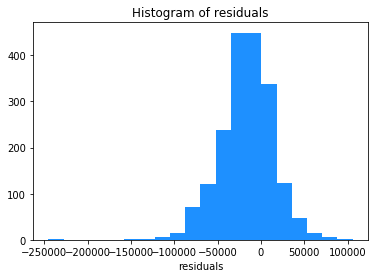

In [66]:
plt.hist(residuals2, bins=20, color = 'dodgerblue');
plt.title('Histogram of residuals'); 
plt.xlabel('residuals');

It looks like this condition is met. The last condition is the the residuals should have equal variance for each predicted value.

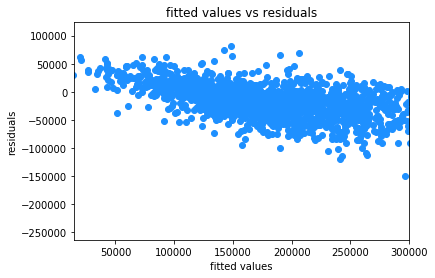

In [67]:
plt.scatter(pred2, residuals2, color ='dodgerblue');
plt.title('fitted values vs residuals')
plt.xlabel('fitted values')
plt.ylabel('residuals');
plt.xlim(15000, 300000);

While there might be a slight variation towards the inexpensive houses the residuals look fairly constant. This condition looks met enought to proceed with inference.

In [68]:
print(lr2.intercept_)
print(lr2.coef_)

164859.85114718397
[23228.78192302 16496.41856124  8804.29285609  7197.80289864
  -442.31857707  4257.50923058  2905.4402822   7990.76091902]


In [69]:
list(zip(X.columns, lr2.coef_))

[('Overall Qual', 23228.7819230184),
 ('Gr Liv Area', 16496.41856123732),
 ('Garage Area', 8804.292856093094),
 ('Total Bsmt SF', 7197.802898641518),
 ('Mas Vnr Area', -442.31857707145264),
 ('Fireplaces', 4257.509230580838),
 ('NridgHt', 2905.440282195942),
 ('BsmtFin SF 1', 7990.760919016816)]

The coefficients can be used to draw inferences about how the features effect sale price. It is important to remember that the features are scailed. Therefore the coefficients represent the increase in sales price when the feature is raised one deviation and all other things are held constant. 

For instance a 1 standard deviation increase in overall quality raises the price of sale 23228 dollars. Of all the features Overall Quality has the biggest coefficient. That makes sense since it was most correlated with sale price to begin with. The next biggest coefficient is Ground Living Area. One standard deviation increase in that increases the sale price by 16496 dollars. 

The inferential model can be used by prospective buyers to find good deals. For instance if a prospective buyer does not care about fireplaces they migh look for a home with fewer fireplaces since they know that each additional standard deviation of fireplaces will raise the price more than 4000 dollars.

Another inferential model will be run for more expensive houses. 

In [70]:
df3 = df[(df['SalePrice'] > 300000)]

In [71]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Mas Vnr Area', 'Fireplaces', 'NridgHt','BsmtFin SF 1'] # set up the features and output for models
X3 = df3[features]
y3 = df3['SalePrice']
sc = StandardScaler()
Xs3 = sc.fit_transform(X3)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(Xs3, y3, random_state = 5) # set up the regression and split the data
lr3 =LinearRegression()
lr3.fit(X_train, y_train);

In [73]:
cross_val_score(estimator = lr3,
               X = X_train,
               y = y_train).mean()

0.528063284968375

In [74]:
lr3.score(X_train, y_train)

0.6333080515585198

In [75]:
lr3.score(X_test, y_test)

0.5096024525088488

Unlike the other models. this model is not very good. It also has overfitting. However if line conditions are met we can still use it for inference.

In [76]:
pred3 =lr.predict(Xs3) #make predictions
residuals3 = y3 -pred3 #get residuals 

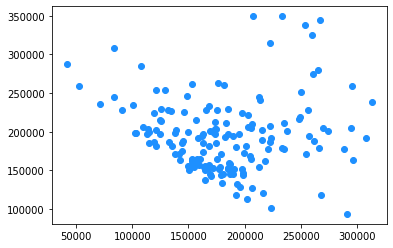

In [77]:
plt.scatter(pred3, residuals3, color ='dodgerblue');

Unfortuantely, line conditions are not met. I was unable to come up with a model that met the line conditions for more expensive houses. This will be discussed further in the future work section. The good news is that since the majority of the houses in our town are cheaper then the threshold our inferential model with be useful for most residents.

# Conclusion 

We have successfully come up with a model that can explain over 80% of the variation in sale prices and does not seem to suffer from underfitting and overfitting. We can use the model to estimate how much a house will go for. This will allow us to provide reasonable estimates to prospective buyers and sellers. By providing it to the public we can perform a service to the people in Ames. We also might be able to get people to move from neighbooring towns if they find our model makes the house buying process easier and less stressful. 

Our inferential model allows people to interpret coefficients for houses less then 300000 dollars. By interpreting the coefficients home buyers can see how various factors impact the price of a house.

Further work needs to be done to come up with an inferential model that works on houses that sell for over 300000 dollars. That way there will be a model for all prosective house buyers to perform inference on. 

Further work could be done by running a grid search and refining the model. In addition collecting more information, might make the model even better. Also we could provide the model to other cities so they can tweak the model for their cities.